In [29]:
import pandas as pd 

In [30]:
# edge_list = pd.read_csv('DataDiatomGNN_GTstudentprojectGT/EdgeList_GTstudentproject_Watershed=Loire-Bretagne_477MostFrequentTaxa_RelAb_spearman_rhothr=0.0321.csv', sep=';')
edge_list = pd.read_csv('DataDiatomGNN_GTstudentprojectGT/EdgeList_GTstudentproject_AllFrance_780MostFrequentTaxa_RelAb_spearman_rhothr=0.0131.csv', sep=';')
edge_list['Cooc'] = edge_list['Cooc'].str.replace(',','.')
edge_list['Cooc'] = edge_list['Cooc'].astype(float)

100%|██████████| 10307/10307 [01:15<00:00, 136.87it/s]


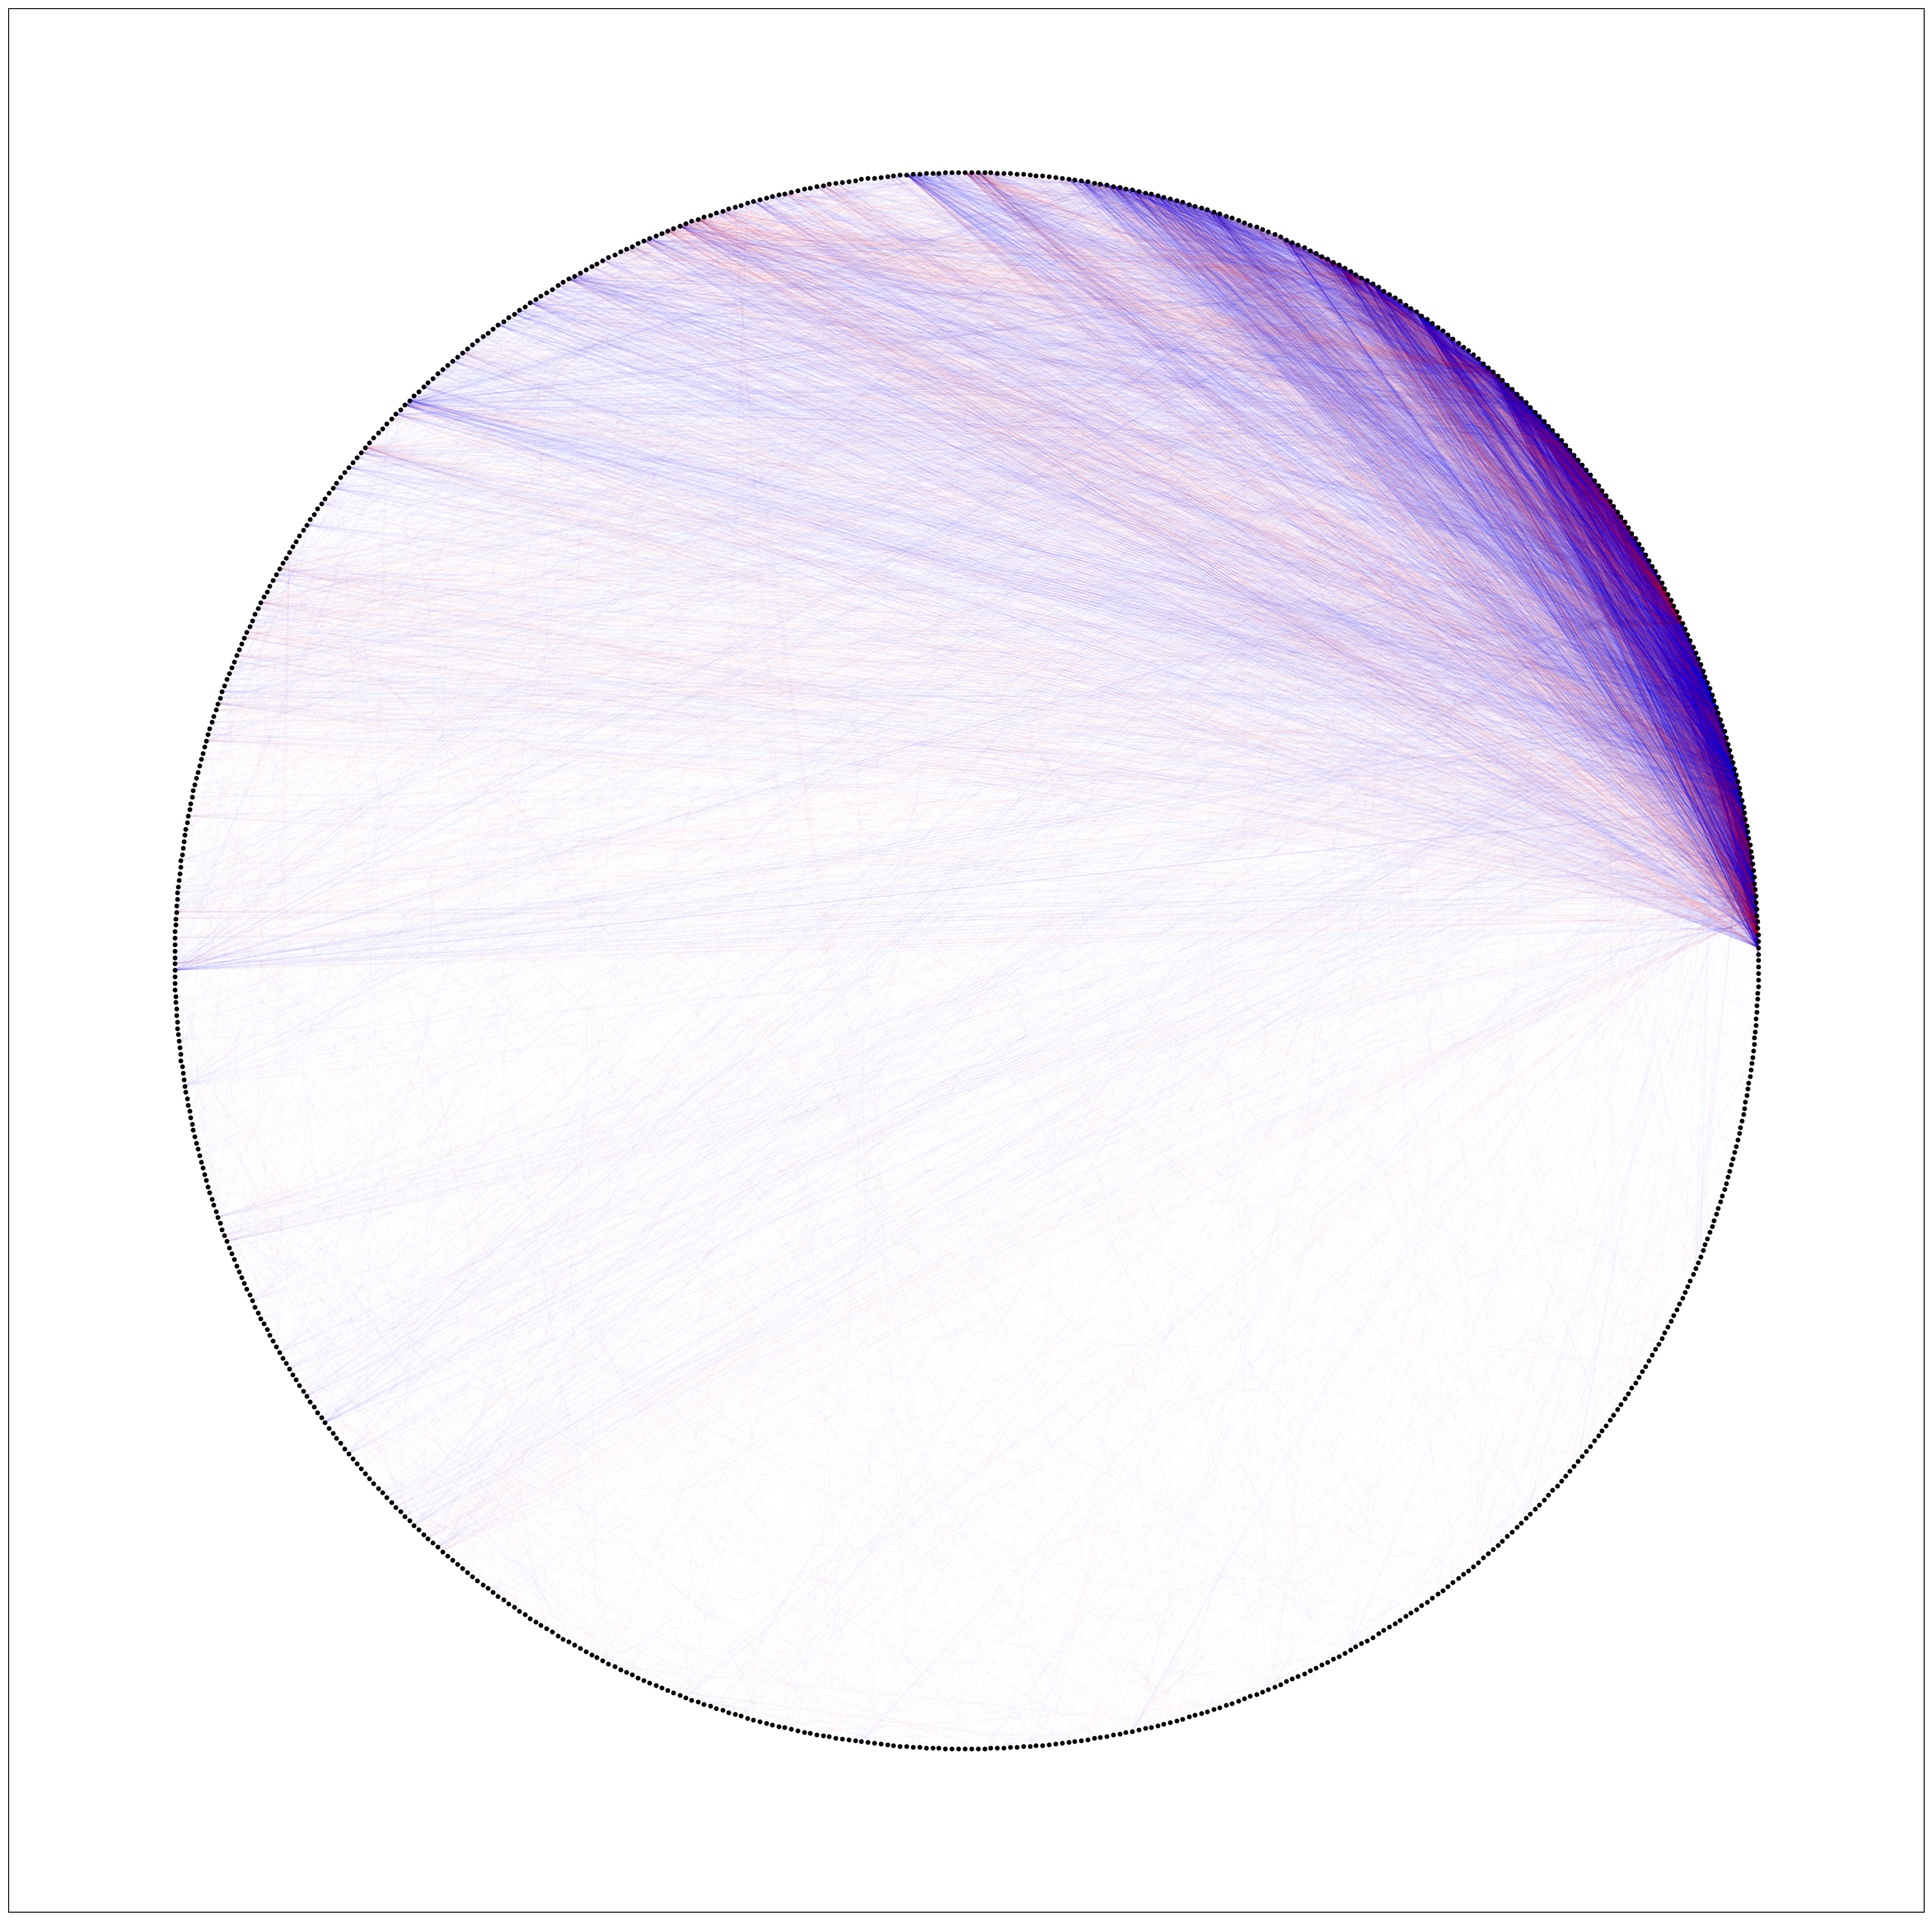

In [31]:
# visualize the edge list graph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

cleaned = edge_list.copy()
cleaned = cleaned[cleaned['Cooc'] != 0]
cleaned = cleaned[cleaned['TaxonCode_1'] != cleaned['TaxonCode_2']]
cleaned_G = nx.from_pandas_edgelist(cleaned, 'TaxonCode_1', 'TaxonCode_2', ['Cooc'])
G = nx.from_pandas_edgelist(edge_list, 'TaxonCode_1', 'TaxonCode_2', ['Cooc'])
plt.figure(figsize=(30, 30))
options = {
    'node_color':'black',
    'node_size':10
}
node_pos = nx.circular_layout(cleaned_G)
nx.draw_networkx_nodes(cleaned_G,pos=node_pos, **options)
for node1, node2, weight in tqdm(cleaned_G.edges(data='Cooc')):
    if node1 == node2:
        continue
    if weight < 0:
        if weight < -1:
            nx.draw_networkx_edges(cleaned_G, pos=node_pos, edgelist=[(node1, node2)], alpha=1, edge_color='red')
        else:
            nx.draw_networkx_edges(cleaned_G, pos=node_pos, edgelist=[(node1, node2)], alpha=-weight, edge_color='red')
    else:
        if weight > 1:
            nx.draw_networkx_edges(cleaned_G, pos=node_pos, edgelist=[(node1, node2)], alpha=1, edge_color='blue')
        else:
            nx.draw_networkx_edges(cleaned_G, pos=node_pos, edgelist=[(node1, node2)], alpha=weight,  edge_color='blue')
plt.show()

In [32]:
# save the graph
nx.write_gexf(G, 'entire_graph_all_France.gexf')

In [33]:
import pickle as pkl
diatoms_per_sampling_operation = pkl.load(open('diatoms_per_sampling_operation.pkl', 'rb'))

In [34]:
with open('taxon_to_onehot.txt', 'rb') as f:
    taxons = f.readlines()
    taxons = [x.decode('utf-8').strip() for x in taxons]
sampling_ops = list(diatoms_per_sampling_operation.keys())

  0%|          | 0/210 [00:00<?, ?it/s]

100%|██████████| 210/210 [00:00<00:00, 1831.62it/s]


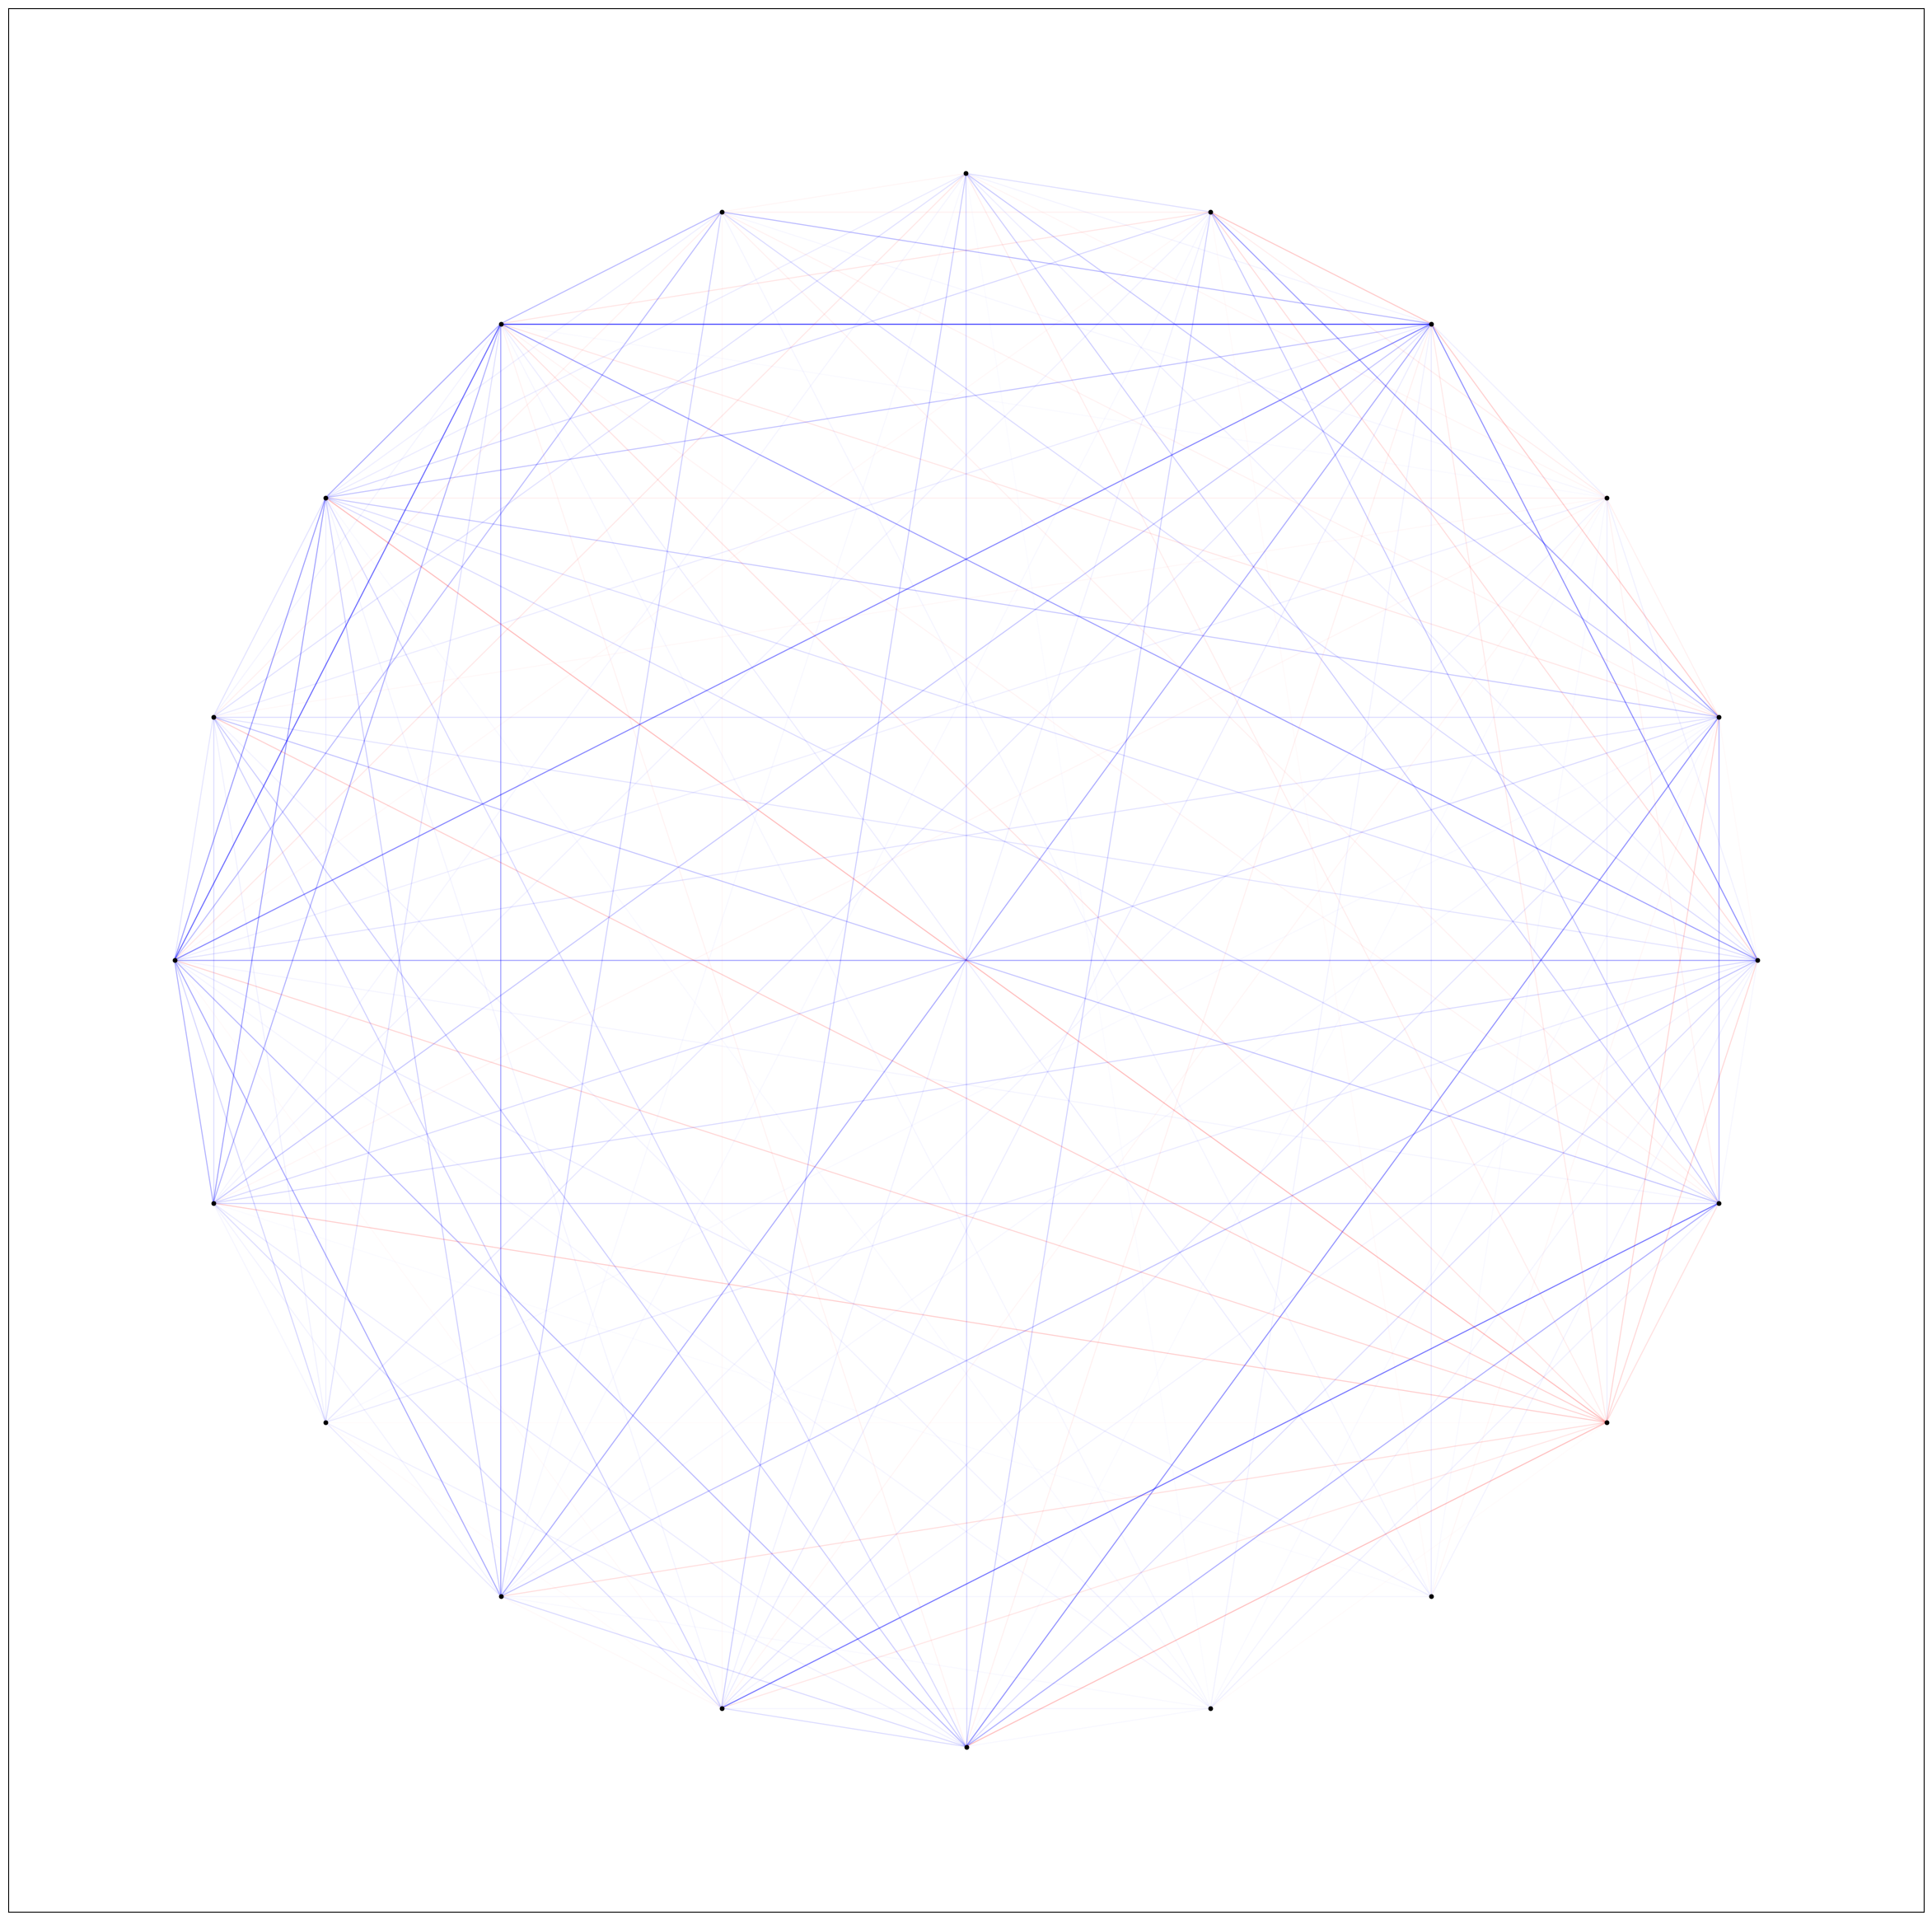

In [35]:
sampling_op = sampling_ops[0]
present_diatoms = diatoms_per_sampling_operation[sampling_op]
present_taxon_codes = [taxons[i] for i in present_diatoms['onehot']]
G_sub = G.subgraph(present_taxon_codes)
plt.figure(figsize=(30, 30))
options = {
    'node_color':'black',
    'node_size':10
}
node_pos = nx.circular_layout(G_sub)
nx.draw_networkx_nodes(G_sub,pos=node_pos, **options)
for node1, node2, weight in tqdm(G_sub.edges(data='Cooc')):
    if node1 == node2:
        continue
    if weight < 0:
        if weight < -1:
            nx.draw_networkx_edges(G_sub, pos=node_pos, edgelist=[(node1, node2)], alpha=1, edge_color='red')
        else:
            nx.draw_networkx_edges(G_sub, pos=node_pos, edgelist=[(node1, node2)], alpha=-weight, edge_color='red')
    else:
        if weight > 1:
            nx.draw_networkx_edges(G_sub, pos=node_pos, edgelist=[(node1, node2)], alpha=1, edge_color='blue')
        else:
            nx.draw_networkx_edges(G_sub, pos=node_pos, edgelist=[(node1, node2)], alpha=weight, edge_color='blue')
plt.show()



In [9]:
# create a subgraph for each sampling operation and save it as a pytorch geometric graph
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.utils import add_self_loops

def create_graph(sampling_op):
    present_diatoms = diatoms_per_sampling_operation[sampling_op]
    present_taxon_codes = [taxons[i] for i in present_diatoms['onehot']]
    G_sub = G.subgraph(present_taxon_codes)
    node_attrs = {}
    abundancies = {}
    for i, node in enumerate(G_sub.nodes):
        node_attrs[node] = taxons.index(node)
        onehot = taxons.index(node)
        abundancies[taxons.index(node)] = list(present_diatoms[present_diatoms['onehot'] == taxons.index(node)]['Abundance_pm'])[0]
    nx.set_node_attributes(G_sub, node_attrs, 'onehot')
    # remove all edges with weight 0
    G_sub_cleaned = G_sub.copy()
    for node1, node2, weight in G_sub.edges(data='Cooc'):
        if weight == 0:
            G_sub_cleaned.remove_edge(node1, node2)
    data = from_networkx(G_sub_cleaned, group_edge_attrs=['Cooc'], group_node_attrs=['onehot'])
    return data, abundancies

for sampling_op in tqdm(sampling_ops):
    data, abundancies = create_graph(sampling_op)
    data.x = data.x.squeeze()
    if not isinstance(data.x, torch.Tensor):
        data.x = torch.atleast_1d(data.x)
    data.x = data.x.long()
    data.edge_index, data.edge_attr = add_self_loops(data.edge_index, data.edge_attr, fill_value=1.0)
    data.edge_attr = (data.edge_attr + 1) / 2.0 + .00001
    data.abundancies = torch.tensor([abundancies[onehot.item()] for onehot in torch.atleast_1d(data.x)])
    torch.save(data, f'france_wide_graphs/{sampling_op}.pt')
    


100%|██████████| 49231/49231 [16:11<00:00, 50.65it/s] 


In [50]:
import os
edge_lists = {}
# for each file in folder EdgeListsHER&ShapeFilesHER_GTstudentproject/EdgeLists_HERlvl1/
# read the file and store it in a dictionary
for file in os.listdir('EdgeListsHER&ShapeFilesHER_GTstudentproject/EdgeLists_HERlvl1/'):
    if file.endswith('.csv'):
        edge_list = pd.read_csv(f'EdgeListsHER&ShapeFilesHER_GTstudentproject/EdgeLists_HERlvl1/{file}', sep=';')
        edge_list['Cooc'] = edge_list['Cooc'].str.replace(',','.')
        edge_list['Cooc'] = edge_list['Cooc'].astype(float)
        code = int(file.split('_')[3].split('=')[1])
        edge_lists[code] = nx.from_pandas_edgelist(edge_list, 'TaxonCode_1', 'TaxonCode_2', ['Cooc'])

print('Graphs processed')

site_infos = pd.read_csv('DataDiatomGNN_GTstudentprojectGT/InfoSamplingsites_GTstudentproject.csv', sep=';')
def create_graph_per_herlvl1(sampling_op):
    site = sampling_op.split('_')[0]
    her_code = int(site_infos[site_infos['CodeSite_SamplingOperations'] == site]['HERlvl1Code'].values[0])
    present_diatoms = diatoms_per_sampling_operation[sampling_op]
    present_taxon_codes = [taxons[i] for i in present_diatoms['onehot']]
    G_sub = edge_lists[her_code].subgraph(present_taxon_codes)
    node_attrs = {}
    abundancies = {}
    for i, node in enumerate(G_sub.nodes):
        node_attrs[node] = taxons.index(node)
        onehot = taxons.index(node)
        abundancies[taxons.index(node)] = list(present_diatoms[present_diatoms['onehot'] == taxons.index(node)]['Abundance_pm'])[0]
    nx.set_node_attributes(G_sub, node_attrs, 'onehot')
    if len(G_sub.nodes) == 0:
        return None, None
    # remove all edges with weight 0
    G_sub_cleaned = G_sub.copy()
    for node1, node2, weight in G_sub.edges(data='Cooc'):
        if weight == 0:
            G_sub_cleaned.remove_edge(node1, node2)
    
    data = from_networkx(G_sub_cleaned, group_edge_attrs=['Cooc'], group_node_attrs=['onehot'])
    return data, abundancies

sampling_ops_to_remove = []
for sampling_op in tqdm(sampling_ops):
    data, abundancies = create_graph_per_herlvl1(sampling_op)
    if data is None:
        sampling_ops_to_remove.append(sampling_op)
        continue
    data.x = data.x.squeeze()
    if not isinstance(data.x, torch.Tensor):
        data.x = torch.atleast_1d(data.x)
    data.x = data.x.long()
    data.edge_index, data.edge_attr = add_self_loops(data.edge_index, data.edge_attr, fill_value=1.0)
    data.edge_attr = (data.edge_attr + 1) / 2.0 + .00001
    data.abundancies = torch.tensor([abundancies[onehot.item()] for onehot in torch.atleast_1d(data.x)])
    torch.save(data, f'her_lvl_1/{sampling_op}.pt')

for sampling_op in sampling_ops_to_remove:
    sampling_ops.remove(sampling_op)
    diatoms_per_sampling_operation.pop(sampling_op)


Graphs processed


100%|██████████| 49231/49231 [14:33<00:00, 56.33it/s]   


In [51]:
from torch_geometric.data import DataLoader, Dataset
from copy import deepcopy
import torch

valid_ys = ["Nitrogencompounds_Status1Y","Nitrogencompounds_Status180D","Nitrogencompounds_Status90D","Nitrates_Status1Y","Nitrates_Status180D","Nitrates_Status90D","Phosphorouscompounds_Status1Y","Phosphorouscompounds_Status180D","Phosphorouscompounds_Status90D","Acidification_Status1Y","Acidification_Status180D","Acidification_Status90D","PAH_Status1Y","PAH_Status180D","PAH_Status90D","OrganicMatter_Status1Y","OrganicMatter_Status180D","OrganicMatter_Status90D","SuspendedMatter_Status1Y","SuspendedMatter_Status180D","SuspendedMatter_Status90D","OrganicMicropollutants_Status1Y","OrganicMicropollutants_Status180D","OrganicMicropollutants_Status90D","MineralMicropollutants_Status1Y","MineralMicropollutants_Status180D","MineralMicropollutants_Status90D"]
class GraphDataset_SplitSite(Dataset):
    def __init__(self, root, sampling_op_to_tensor, x='scaled_onehot', y='Nitrogencompounds_Status1Y', sites=set()):
        super().__init__(root, transform=None, pre_transform=None, pre_filter=None)
        self.sampling_op_to_tensor = deepcopy(sampling_op_to_tensor)
        self.keys = list(self.sampling_op_to_tensor.keys())
        self.x = 0 if x == 'scaled_onehot' else 1
        self.y = [valid_ys.index(y)]
        temp = []
        for key in self.keys:
            if self.sampling_op_to_tensor[key][2][self.y].item() == -1:
                continue
            elif key.split('_')[0] not in sites:
                continue
            else:
                temp.append(key)
                self.sampling_op_to_tensor[key][2][self.y] = 1 if self.sampling_op_to_tensor[key][2][self.y].item() >= 2 else 0
        print('Skipped', len(self.keys) - len(temp), 'samples')
        self.keys = temp

        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        data = torch.load(f'{self.root}/{key}.pt')
        data.x = torch.atleast_1d(data.x)
        data.y = torch.tensor([self.sampling_op_to_tensor[key][2][self.y]], dtype=torch.float)
        return data

In [63]:
sampling_op_to_tensor = pkl.load(open('sampling_op_to_tensor.pkl', 'rb'))
for samp in sampling_ops_to_remove:
    sampling_op_to_tensor.pop(samp)
sites = list(set([key.split('_')[0] for key in sampling_op_to_tensor.keys()]))
train_size = int(0.8 * len(sites))
val_size = int(0.1 * len(sites))
test_size = len(sites) - train_size - val_size
print(train_size, val_size, test_size)
rand_ind_train = np.random.choice(len(sites), train_size, replace=False)
train_sites = set([sites[i] for i in rand_ind_train])
temp = set(sites) - train_sites
rand_ind_val = np.random.choice(len(temp), val_size, replace=False)
val_sites = set([sites[i] for i in rand_ind_val])
test_inds = set([i for i in range(len(temp)) if i not in rand_ind_val])
test_sites = set([sites[i] for i in test_inds])
# train_dataset = GraphDataset_SplitSite('graphs', sampling_op_to_tensor, y='Nitrates_Status1Y', sites=train_sites)
# test_dataset = GraphDataset_SplitSite('graphs', sampling_op_to_tensor, y='Nitrates_Status1Y', sites=test_sites)
train_dataset = GraphDataset_SplitSite('her_lvl_1', sampling_op_to_tensor, y='Nitrates_Status1Y', sites=train_sites)
val_dataset = GraphDataset_SplitSite('her_lvl_1', sampling_op_to_tensor, y='Nitrates_Status1Y', sites=val_sites)   
test_dataset = GraphDataset_SplitSite('her_lvl_1', sampling_op_to_tensor, y='Nitrates_Status1Y', sites=test_sites)
y_dist_bin = {0: 0, 1: 0}
for i in range(len(train_dataset)):
    y_dist_bin[train_dataset[i].y.item()] += 1
print('Train Y distribution (0 is Good, 1 is Mediocre/Bad):', y_dist_bin)
y_dist_bin = {0: 0, 1: 0}
for i in range(len(val_dataset)):
    y_dist_bin[val_dataset[i].y.item()] += 1
print('Val Y distribution (0 is Good, 1 is Mediocre/Bad):', y_dist_bin)
y_dist_bin = {0: 0, 1: 0}
for i in range(len(test_dataset)):
    y_dist_bin[test_dataset[i].y.item()] += 1
print('Test Y distribution (0 is Good, 1 is Mediocre/Bad):', y_dist_bin)

6723 840 841
Skipped 10445 samples
Skipped 44344 samples
Skipped 44251 samples


/var/folders/7h/8hn0w0xs40n29dcvw_5nqwch0000gn/T/ipykernel_374/3664049904.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{self.root}/{key}.pt')


Train Y distribution (0 is Good, 1 is Mediocre/Bad): {0: 19043, 1: 19742}
Val Y distribution (0 is Good, 1 is Mediocre/Bad): {0: 2473, 1: 2413}
Test Y distribution (0 is Good, 1 is Mediocre/Bad): {0: 2520, 1: 2459}


In [64]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, node_features, embedding_size, hidden_channels, num_classes):
        super().__init__()
        self.embedding = torch.nn.Embedding(node_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out1 = torch.nn.Linear(hidden_channels, hidden_channels//4)
        self.out2 = torch.nn.Linear(hidden_channels//4, num_classes)

    def forward(self, data):
        x, edge_index, edge_weights = data.x, data.edge_index, data.edge_attr
        x = self.embedding(x) * data.abundancies.reshape(len(data.x), 1) / 1000
        x = self.conv1(x, edge_index, edge_weights)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index, edge_weights)
        x = global_mean_pool(x, data.batch)
        x = F.leaky_relu(self.out1(x))
        x = self.out2(x)
        return x


In [70]:
model = GCN(len(taxons), embedding_size=2292, hidden_channels=512, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5, min_lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


for epoch in range(10):
    correct = 0
    total = 0
    model.train()
    for i, batch in enumerate(train_loader):
        y = batch.y
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, y.long())
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        if i % 200 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}, Accuracy {100 * correct / total}, {i}/{len(train_loader)}')
    print(f'Final Epoch Train Accuracy {100 * correct / total}')
    correct = 0
    total = 0
    model.eval()
    for i, batch in enumerate(val_loader):
        y = batch.y
        output = model(batch)
        _, predicted = torch.max(output.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    print(f'Validation Accuracy {100 * correct / total}')
    scheduler.step(100 * correct / total)

print('Finished Training')

/Users/rithwikseth/miniconda3/envs/water/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/var/folders/7h/8hn0w0xs40n29dcvw_5nqwch0000gn/T/ipykernel_374/3664049904.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True`

Epoch 0, Loss 0.6944061517715454, Accuracy 43.75, 0/2425
Epoch 0, Loss 0.3881903886795044, Accuracy 69.02985074626865, 200/2425
Epoch 0, Loss 0.4312596917152405, Accuracy 70.2150872817955, 400/2425
Epoch 0, Loss 0.5625895261764526, Accuracy 71.42262895174709, 600/2425
Epoch 0, Loss 0.4262174069881439, Accuracy 71.35611735330836, 800/2425
Epoch 0, Loss 0.3373008072376251, Accuracy 72.17782217782218, 1000/2425
Epoch 0, Loss 0.4456638693809509, Accuracy 72.47606161532056, 1200/2425
Epoch 0, Loss 0.5211194157600403, Accuracy 72.96573875802999, 1400/2425
Epoch 0, Loss 0.5937313437461853, Accuracy 73.37601499063085, 1600/2425
Epoch 0, Loss 0.2869141101837158, Accuracy 73.40713492504165, 1800/2425
Epoch 0, Loss 0.5103588700294495, Accuracy 73.5632183908046, 2000/2425
Epoch 0, Loss 0.5021879076957703, Accuracy 73.62846433439346, 2200/2425
Epoch 0, Loss 0.4319947361946106, Accuracy 73.8390254060808, 2400/2425
Final Epoch Train Accuracy 73.87134201366507
Validation Accuracy 76.87269750307
Epoch 

  0%|          | 0/312 [00:00<?, ?it/s]/var/folders/7h/8hn0w0xs40n29dcvw_5nqwch0000gn/T/ipykernel_374/3664049904.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = 

Final Test Accuracy 76.22012452299658


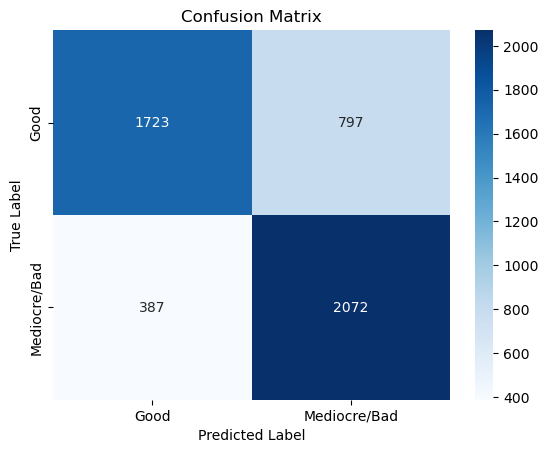

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

correct = 0
total = 0
predictions = []
true_classes = []
site_outputs = {}

model.eval()
for i, batch in enumerate(tqdm(test_loader)):
    y = batch.y
    output = model(batch)
    _, predicted = torch.max(output.data, 1)
    predictions.extend(predicted)
    true_classes.extend(y)
    total += y.size(0)
    correct += (predicted == y).sum().item()
    # for j, key in enumerate(keys):
    #     k = key.split('_')[0]
    #     if k in site_outputs:
    #         site_outputs[k].append(predicted[j].item() == y[j].item())
    #     else:
    #         site_outputs[k] = [predicted[j].item() == y[j].item()]
print(f'Final Test Accuracy {100 * correct / total}')
conf_matrix = confusion_matrix(true_classes, predictions)

# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
#           xticklabels=['High', 'Good', 'Mediocre', 'Poor', 'Bad'],
#            yticklabels=['High', 'Good', 'Mediocre', 'Poor', 'Bad'])

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=['Good', 'Mediocre/Bad'],
            yticklabels=['Good', 'Mediocre/Bad'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# site_acc = {key: np.mean(val) for key, val in site_outputs.items()}
# sns.boxplot(x=list(site_acc.values()))
# plt.xlabel('Accuracy')
# plt.title('Site Accuracy')
# plt.show()

# sns.histplot(list(site_acc.values()))
# plt.xlabel('Accuracy')
# plt.title('Site Accuracy')
# plt.show()